# END-TO-END COST BENEFIT CALCULATION

### Goal of this tutorial

The goal of this tutorial is to show a full end-to-end cost-benefit calculation. Note that this tutorial examplifies the work flow, but does not explore all possible features.

The tutorial will start with an explanation of the mathematics of an cost-benefit calculation, and then will move on to how this is implemented in CLIMADA. We will then go through an end-to-end calculation. If you just need to see the code in action, you can skip these first parts.

The tutorial assumes that you're already familiar with CLIMADA's hazard, exposures, impact functions, impact and adaptation measure functionality.

If you aren't yet familiar with Impact calculations, read the high-level __[introductory tutorial](1_main_climada.ipynb)__ or the __[Impact class tutorial](climada_engine_Impact.ipynb)__.

__[Part1](#part1)__: Detailed impact calculation with Litpop and TropCyclone

__[Part2](#part2)__: Quick examples: raster and point exposures/hazards

__[Part3](#part3)__: Visualization methods

### What is a cost-benefit?

A cost-benefit analysis in CLIMADA lets you compare the effectiveness of different hazard adaptation options.

The cost-benefit ratio describes how much loss you can prevent per dollar of expenditure (or whatever currency you're using) over a period of time. When a cost-benefit ratio is less than 1, the cost is less than the benefit and CLIMADA is predicting a worthwhile investment. Smaller ratios therefore represent better investments. When a cost-benefit is greater than 1, the cost is more than the benefit and the offset losses are less than the cost of the adaptation measure: based on the financials alone, the measure may not be worth it. Of course, users may have factors beyond just cost-benefits that influence decisions. 

CLIMADA doesn't limit cost-benefits to just financial exposures. The cost-benefit ratio could represent hospitalisations avoided per Euro spent, or additional tons of crop yield per Swiss Franc.

The cost-benefit calculation has a few complicated components, so in this section we'll build up the calculation step by step.

#### Simple cost-benefits

The simplest form of a cost-benefit calculation goes like this:

$$
\text{CostBenefit} = \frac{\text{cost}}{\text{benefit}} = \frac{\text{cost}}{N * (\text{present AAI without measures} - \text{future AAI with measures})}
$$

where $\text{cost}$ is the cost of implementing a set of measures, the AAI is the average annual impact from your hazard event set on your exposure, and $N$ is the number of years the cost-benefit is being evaluated over.

Note that:
- Whether an adaptation measure is seen to be effective might depend on the number of years you are evaluating the cost-benefit over. For example, a \\$50 mn investment that prevents and average of \\$1 mn losses per year will only 'break even' after $n \ge 50$ years.
- Since an adaptation measure could in theory make an impact worse (a negative benefit) it is possible to have negative cost-benefit ratios.
- CLIMADA allows you to use other methods than annual average impact, but to keep thing simple we'll use average annual impact throughout this tutorial.

#### Time-dependence

The equation works well when the only thing changing between your present and future impacts is an adaptation measure implemented in the first year. But usually a climate change impact calculation will want to deal with a climate and exposure that also change over time. In this case it's not enough to multiply the change in average annual impact by the number of years we're evaluating over, and we need to calculate the benefit for every year and sum them up.

We can modify the benefit part of cost-benefit to reflect this. CLIMADA doesn't assume that the user will have explicit hazard and impact objects for every year in the study period, and so interpolates between the impacts at the start and the end of the period of interest. If we're evaluating between years $T_0$, usually the present, and $T_1$ in the future, then we can say:

$$
\text{benefit} = \sum_{t = T_0}^{T_1} \alpha(t) \bigg{(} \text{AAI with measures}_{T_1} - \text{AAI with measures}_{T_0} \bigg{)} - N * \text{AAI without measure}_{T_0}
$$

Where $\alpha(t)$ is a function of the year $t$ and giving values in the range $[0, 1]$, usually with $\alpha(T_0) = 0$ and $\alpha(T_0) = 1$.

Note that:
- This calculation now requires three separate impact calculations: present-day impacts without measures implemented, present-day impacts with measures implemented, and future impacts with measures implemented.
- Setting $\alpha(t) = 1$ for all values of $t$ simplifies this to the first cost-benefit equation in the tutorial.

CLIMADA lets you set $\alpha(t)$ to 1 for all years $t$, or as
$$
\alpha_k(t) = \frac{(t - T_0)^k}{(T_1 - T_0)^k}  \;\; \text{for} \; t \in [T_0, T_1]
$$

where $k$ is user-provided. This expression is a polynomial curve between $T_0$ and $T_1$ normalised so that $\alpha_k(T_0) = 0$ and $\alpha_k(T_1) = 1$. The choice of $k$ determines how quickly the transition occurs between the past and future. When $k = 1$ the function is a straight line. When $k > 1$ change begins slowly and speeds up over time. When $k < 1$ change is begins quickly and slows over time. We'll see this implemented later in the tutorial.

#### Discount rates

The final addition to our cost-benefit calculation is the *discount rate*.

The discount rate tries to formalise an idea from economics that says that a gain in the future is worth less to us than the same gain right now. For example, paying \\$1 mn to offset \\$2 mn of economic losses next year is somehow worth more than paying \\$1 mn to offset \\$2 mn of economic losses in 2080.

In practice it provides a way to convert between past and future monetary values to estimated worth today, called their *net present value*. Note that this is *not* an adjustment for inflation.

The choice of discount rate is a contentious topic in adaptation finance, since it can strongly affect a cost-benefit calculation. The most widley used discount rate in climate change economics is 1.4% as proposed by the Stern Review (2006). Neoliberal economists around Nordhaus (2007) claim that rates should be higher, around 4.3%, reflecting continued economic growth and a society that will be better at adapting in future. Environmental economists argue that future costs shouldn't be discounted at all.

To illustrate, with a 1.4\% annual discount rate a gain of \\$100 next year is equivalent to \\$98.60 this year, and a gain of \\$100 in 20 years is equivalent to
$$
$ (100 * 0.986^{15}) = $ 80.94
$$
this year. With a rate of 4.3\% this drops to \\$51.72.

We can add this into the cost-benefit calculation by defining $d(t)$, the discount rate for each year. A constant rate of 1.4\% would then set $d(t) = 0.014$ for all values of $t$.

Then the adjustment $D(t)$ from year $t$ to the net present value in year $T_0$ is given by

$$
D(t) = \prod_{y = T_0}^{t} (1 - d(y))
$$

With a constant 1.4\% discount rate gives $D(t) = 0.986^{t - T_0}$.

Adding this to our equation for total benefits we get:

$$
\text{benefit} = \sum_{t = T_0}^{T_1} \alpha(t) D(t) \bigg{(} \text{AAI with measures}_{T_1} - \text{AAI with measures}_{T_0} \bigg{)} - N * \text{AAI without measure}_{T_0}
$$

Note:
- Setting the rates to zero ($d(t) = 0$) means $D(t) = 1$ and the term drops out of the equation.
- Be careful with your choice of discount rate when your exposure is non-economic. It can be hard to justify applying rates to e.g. ecosystems or human lives.


### CostBenefit class data structure

The CostBenefit class does not require any attributes to be defined by the user. All attributes are set from parameters when the method `CostBenefit.calc()` is called.

After calling the method the `CostBenefit` object has the following attributes:

| Attributes created in `CostBenefit.calc` | Data Type | Description|
| :- | :- | :- |
| present_year | int | The current year |
| future_year | int | The future scenario year |
| tot_climate_risk | float | The total climate risk in the present scenario, evaluated according to the provided risk function (annual average impact by default) |
| unit | string | Units to measure impact |
| benefit | dict(float) | The benefit of each measure, keyed by measure name |
| cost_ben_ratio | dict(float) | The cost benefit of each measure, keyed by measure name |
| imp_meas_future | dict(dict) | Dictionaries describing the impacts of each measure in the future scenario. Keyed by measure name (with 'no measure' for no measures). The entries in each dictionary are described below. |
| imp_meas_present | dict(dict) | Dictionaries describing the impacts of each measure in the present-day scenario. Keyed by measure name (with 'no measure' for no measures). The entries in each dictionary are described below. |


Each dictionary stored in the attributes `imp_meas_future` and `imp_meas_present` has entries:

| Key | Data Type | Description |
| :- | :- | :- |
| cost | tuple (cost measure, cost factor insurance) | The cost of implementing the measure, and the cost factor if risk transfers are being calculated |
| impact | Impact | Impact object calculated with the present (`imp_meas_present`) or future (`imp_meas_future`) hazard, exposure and impact functions |
| risk | float | A value of annual risk used in the cost-benefit calculation. A summary statistic calculated from the Impact object. Most commonly the average annual impact, but can be changed with the `CostBenefit.calc`'s `risk_func`parameter. |
| risk_transf | float | Annual expected risk transfer (if calculated) |
| efc | ImpactFreqCurve | The impact exceedance freq for this measure calculated from the Impact object (if calculated) |


The dictionary will also include a 'NO_MEASURE' entry with the same structure, giving the impact analysis when no measures are implemented.

Let's look at the parameters needed for the calculation:
```
CostBenefit.calc(hazard, entity, haz_future=None, ent_future=None,
                 future_year=None, risk_func=risk_aai_agg, imp_time_depen=None, save_imp=False)
```

These are:
- `hazard` (Hazard object): the present-day or baseline hazard event set
- `entity` (Entity object): the present-day or baseline Entity object. `Entity` is the container class containing 
    - `exposure` (Exposures object): the present-day or baseline exposure
    - `disc_rates` (DiscRates object): the discount rates to be applied in the cost-benefit calculation. The default value is no discount rate.
    - `impact_funcs` (ImpactFuncSet object): the impact functions required to calculate impacts from the present-day hazards and exposures
    - `measures` (MeasureSet object): the set of measures already existing in the present day. Most analyses will leave this empty.
- `haz_future` (Hazard object, optional): the future hazard event set, if different from present.
- `ent_future` (Entity object, optional): the future Entity, if different from present. Note that the same adaptation measures must be present in both `entity` and `ent_future`: the cost-benefit calculation can't compare portfolios.

# ^HOW DOES THIS BEHAVE

- `future_year` (int): the year of the future scenario. This is only used if the Entity's `exposures.ref_year` isn't set, or no future entity is provided. 
- `risk_func` (function): this is the risk function used to describe the annual impacts used to describe benefits. The default is `risk_aai_agg`, the average annual impact on the Exposures (defined in the CostBenefit module). This function can be replaces with any function that takes an Impact object as input and returns a number. The CostBenefit module provides two others functions `risk_rp_100` and `risk_rp_250`, the 100-year and 250-year return period impacts respectively.


## Detailed CostBenefit calculation - LitPop + TropCyclone
<a id='part1'></a> 

We present a detailed example for the hazard __[Tropical Cyclones](climada_hazard_TropCyclone.ipynb)__ and the exposures from __[LitPop](climada_entity_LitPop.ipynb)__ .

To speed things up we'll use the CLIMADA Data API to download the data as needed. The data download roughly follows the __[Data API tutorial](climada_util_api_client.ipynb)__ for Haiti. If this is a problem you can build tropical cyclone event sets, and LitPop exposures following the relevant tutorials.

#### Download hazard

We will get data for present day tropical cyclone hazard in Haiti, and for 2080 hazard under the RCP 8.5 warming scenario. Note that the Data API provides us with a full event set of wind footprints rather than a TCTracks track dataset, meaning we don't have to generate the wind fields ourselves.

In [2]:
from climada.util.api_client import Client

client = Client()
haz_present = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'historical',
                                            'nb_synth_tracks':'10'})
haz_future = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'rcp85',
                                            'ref_year':'2080',
                                            'nb_synth_tracks':'10'})


2022-03-02 23:56:34,645 - climada.hazard.base - INFO - Reading /Users/chrisfairless/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v1/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2022-03-02 23:56:41,514 - climada.hazard.base - INFO - Reading /Users/chrisfairless/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp85_HTI_2080/v1/tropical_cyclone_10synth_tracks_150arcsec_rcp85_HTI_2080.hdf5


2022-03-03 00:12:49,320 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [50]
2022-03-03 00:12:57,359 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [50]


(<GeoAxesSubplot:title={'center':'Return period: 50 years'}>,
 array([[41.84896948, 41.98439726, 41.62016887, ..., 49.52344953,
         51.35294266, 51.51945831]]))

/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(

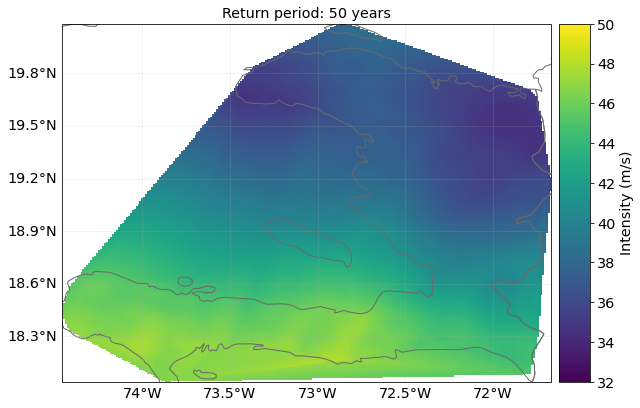

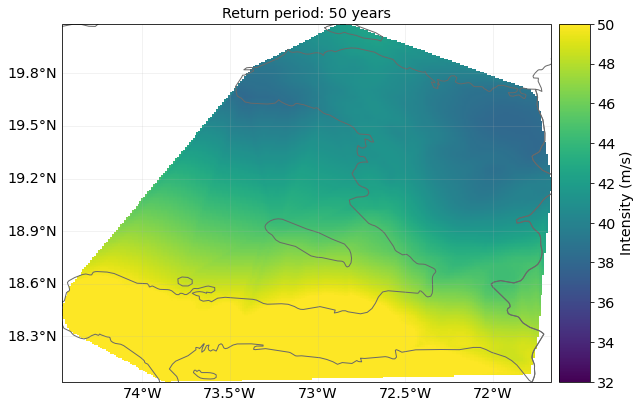

In [17]:
# Plot the hazards, showing 50-year return period hazard
haz_present.plot_rp_intensity(return_periods=(50,), smooth=False, vmin=32, vmax=50)
haz_future.plot_rp_intensity(return_periods=(50,), smooth=False, vmin=32, vmax=50)

#### Download LitPop economic exposure data

The Data API provides us with economic exposure data:

In [18]:
exp_present = client.get_property_values(litpop_dataset_infos,
                                         known_property_values = {'fin_mode':'pc', 'exponents':'(1,1)'})

AttributeError: 'Client' object has no attribute 'get_property_values'

For 2080's economic exposure we will use a crude approximation, assuming the country will experience 2% economic growth annually:

In [ ]:
import copy

exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = 2080
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate ** n_years
exp_future.gdf['value'] = exp_future.gdf['value'] * growth

2021-04-30 13:11:13,034 - climada.util.coordinates - INFO - Raster from resolution 0.0833333333333286 to 0.0833333333333286.

 Raster properties exposures: {'width': 129, 'height': 41, 'crs': 'EPSG:4326', 'transform': Affine(0.0833333333333286, 0.0, -84.91666666666669,
       0.0, 0.0833333333333286, 19.833333333333336)}


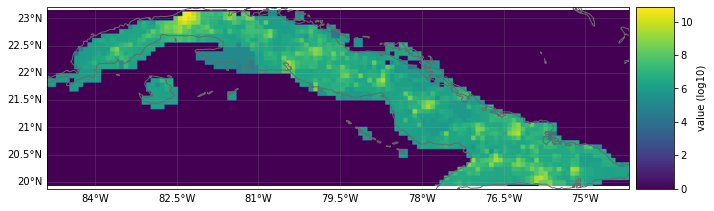

In [3]:

exp_present.plot_raster()

We then need to map the exposure points to the hazard centroids. (Note: we could have done this earlier before we copied the exposure, but not all analyses will have present and future exposures and hazards on the same sets of points.)

In [ ]:
exp_present.assign_centroids(haz_present, distance='approx')
exp_future.assign_centroids(haz_future, distance='approx')

#### Define impact function

You've likely done this many times already! We'll use the popular Emanuel sigmoid curve:

In [ ]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_all = ImpactFuncSet()
impf_all.append(impf_tc)

#### Define adaptation measures

For adaptation measures we'll use some of the examples from the __[Adaptation MeasureSet tutorial](climada_entity_MeasureSet.ipynb)__. See the tutorial to understand how measures work in more depth.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from climada.entity.measures import Measure, MeasureSet

meas_1 = Measure()
meas_1.haz_type = 'TC'
meas_1.name = 'Mangrove'
meas_1.color_rgb = np.array([1, 1, 1])
meas_1.cost = 500000000
meas_1.mdd_impact = (1, 2)
meas_1.paa_impact = (1, 2)
meas_1.hazard_inten_imp = (1, 2)
meas_1.risk_transf_cover = 0

meas_2 = Measure()
meas_2.haz_type = 'TC'
meas_2.name = 'Sandbags'
meas_2.color_rgb = np.array([1, 1, 1])
meas_2.cost = 22000000
meas_2.mdd_impact = (1, 2)
meas_2.paa_impact = (1, 3)
meas_2.hazard_inten_imp = (1, 2)

# gather all measures
meas_set = MeasureSet()
meas_set.append(meas_1)
meas_set.append(meas_2)
meas_set.check()

### Impact function 

For Tropical Cyclones, some calibrated default impact functions exist. Here we will use the one from Emanuel (2011).

In [8]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone
# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

2021-10-19 16:49:44,667 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


Recall that the exposures, hazards and impact functions  must be matched in the impact calculations. Here it is simple, since there is a single impact function for all the hazards. We must simply make sure that the exposure is assigned this impact function through renaming the `impf_` column from the hazard type of the impact function in the impact function set and set the values of the column to the id of the impact function. 

In [9]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [10]:
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.check()
exp_lp.gdf.head()

,value,geometry,latitude,longitude,region_id,impf_TC
0,4.730991e+10,POINT (-82.37500 23.12500),23.125,-82.375000,192,1
1,2.990876e+10,POINT (-82.29167 23.12500),23.125,-82.291667,192,1
2,6.839380e+09,POINT (-82.20833 23.12500),23.125,-82.208333,192,1
3,1.925246e+09,POINT (-82.12500 23.12500),23.125,-82.125000,192,1
4,2.422598e+08,POINT (-82.04167 23.12500),23.125,-82.041667,192,1


### Impact computation 

We are finally ready for the impact computation. This is the simplest step. Just give the exposure, impact function and hazard to the Impact.calc() method.

Note: we did not specifically assign centroids to the exposures. Hence, the default is used - each exposure is associated with the closest centroids. Since we defined the centroids from the exposures, this is a one-to-one mapping.

Note: we did not define an `Entity`  in this impact calculations. Recall that `Entity` is a container class for __[Exposures](climada_entity_Exposures.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__, __[Discount Rates](climada_entity_DiscRates.ipynb)__ and __[Measures](climada_entity_MeasureSet.ipynb)__. Since we had only one Exposure and one Impact Function, the container would not have added any value, but for more complex projects, the Entity class is very useful.

In [11]:
# Compute impact
from climada.engine import Impact
imp = Impact()
imp.calc(exp_lp, impf_set, tc, save_mat=False) #Do not save the results geographically resolved (only aggregate values)

In [12]:
exp_lp.gdf

,value,geometry,latitude,longitude,region_id,impf_TC,centr_TC
0,4.730991e+10,POINT (-82.37500 23.12500),23.125000,-82.375000,192,1,0
1,2.990876e+10,POINT (-82.29167 23.12500),23.125000,-82.291667,192,1,1
2,6.839380e+09,POINT (-82.20833 23.12500),23.125000,-82.208333,192,1,2
3,1.925246e+09,POINT (-82.12500 23.12500),23.125000,-82.125000,192,1,3
4,2.422598e+08,POINT (-82.04167 23.12500),23.125000,-82.041667,192,1,4
...,...,...,...,...,...,...,...
1383,6.191982e+06,POINT (-78.29167 22.45833),22.458333,-78.291667,192,1,1383
1384,8.882190e+05,POINT (-79.20833 22.62500),22.625000,-79.208333,192,1,1384
1385,7.629772e+05,POINT (-79.62500 22.79167),22.791667,-79.625000,192,1,1385
1386,9.065058e+05,POINT (-79.45833 22.70833),22.708333,-79.458333,192,1,1386


For example we can now obtain the aggregated average annual impact or plot the average annual impact in each exposure location.

In [13]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 563366225.0 $


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

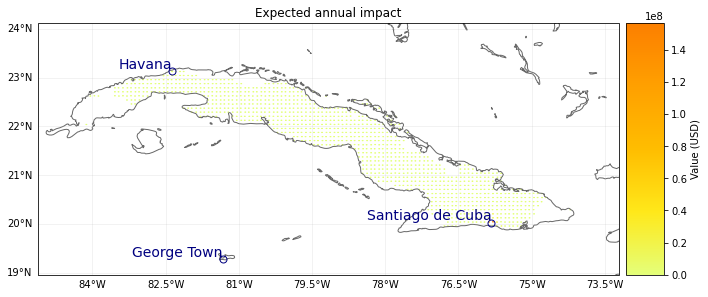

In [14]:
imp.plot_hexbin_eai_exposure(buffer=1)

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

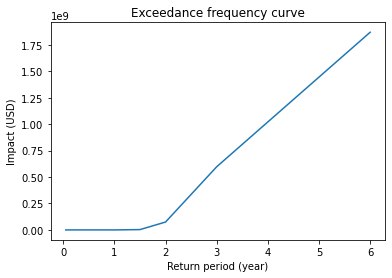

In [15]:
# Compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot()

## Quick examples - points, raster, custom
<a id='part2'></a> 

### User defined point exposure and Tropical Cyclone hazard

2021-10-19 16:49:49,046 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
Nearest neighbor hazard.centroids indexes for each exposure: [0 1 2 3 4 5 6]


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

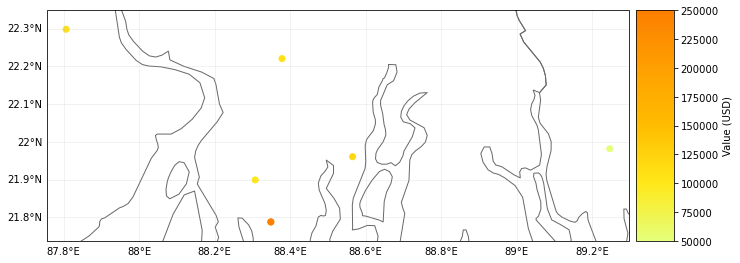

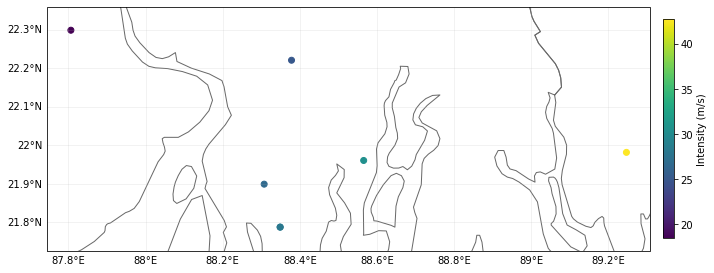

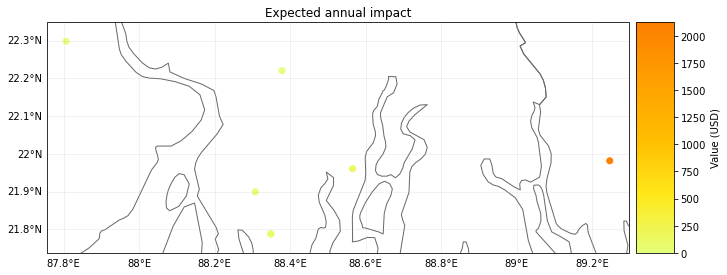

In [16]:
%matplotlib inline
# EXAMPLE: POINT EXPOSURES WITH POINT HAZARD
import numpy as np
from climada.entity import Exposures, ImpactFuncSet, IFTropCyclone
from climada.hazard import Centroids, TCTracks, TropCyclone
from climada.engine import Impact

# Set Exposures in points
exp_pnt = Exposures(crs='epsg:4326') #set coordinate system
exp_pnt.gdf['latitude'] = np.array([21.899326, 21.960728, 22.220574, 22.298390, 21.787977, 21.787977, 21.981732])
exp_pnt.gdf['longitude'] = np.array([88.307422, 88.565362, 88.378337, 87.806356, 88.348835, 88.348835, 89.246521])
exp_pnt.gdf['value'] = np.array([1.0e5, 1.2e5, 1.1e5, 1.1e5, 2.0e5, 2.5e5, 0.5e5])
exp_pnt.check()
exp_pnt.plot_scatter(buffer=0.05)

# Set Hazard in Exposures points
# set centroids from exposures coordinates
centr_pnt = Centroids.from_lat_lon(exp_pnt.gdf.latitude.values, exp_pnt.gdf.longitude.values, exp_pnt.crs)
# compute Hazard in that centroids
tr_pnt = TCTracks.from_ibtracs_netcdf(storm_id='2007314N10093')
tc_pnt = TropCyclone.from_tracks(tr_pnt, centroids=centr_pnt)
tc_pnt.check()
ax_pnt = tc_pnt.centroids.plot(c=np.array(tc_pnt.intensity[0,:].todense()).squeeze()) # plot intensity per point
ax_pnt.get_figure().colorbar(ax_pnt.collections[0], fraction=0.0175, pad=0.02).set_label('Intensity (m/s)') # add colorbar

# Set impact function
impf_pnt = ImpactFuncSet()
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_pnt.append(impf_tc)
impf_pnt.check()

# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.gdf.head()

# Compute Impact
imp_pnt = Impact()
imp_pnt.calc(exp_pnt, impf_pnt, tc_pnt)
# nearest neighbor of exposures to centroids gives identity
print('Nearest neighbor hazard.centroids indexes for each exposure:', exp_pnt.gdf.centr_TC.values)
imp_pnt.plot_scatter_eai_exposure(ignore_zero=False, buffer=0.05)

### Raster from file 

2021-10-19 16:49:51,864 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020

 Raster properties exposures: {'width': 163, 'height': 138, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(0.08333333000000209, 0.0, -73.41666666500001,
       0.0, -0.08333332999999987, 12.166666665)}
Raster properties centroids: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 163, 'height': 138, 'count': 1, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Green

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

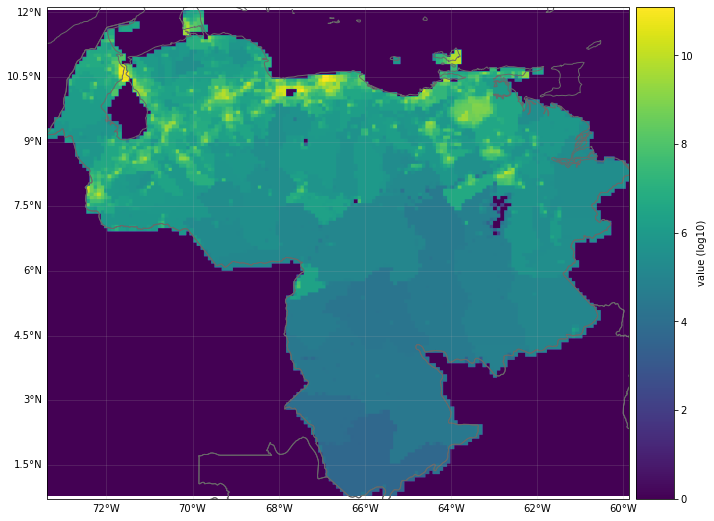

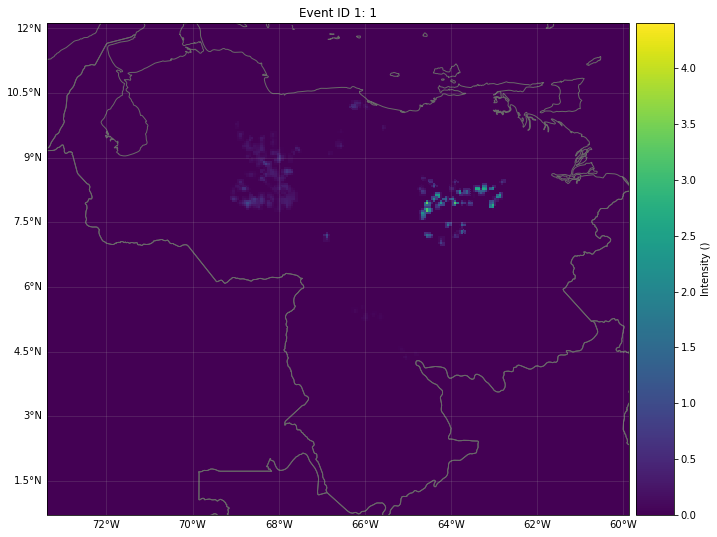

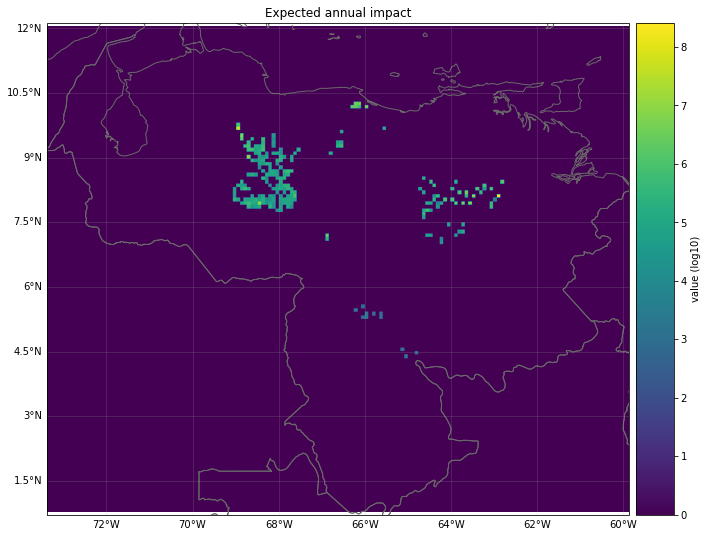

In [17]:
# EXAMPLE: RASTER EXPOSURES WITH RASTER HAZARD
from rasterio.warp import Resampling
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.util.constants import HAZ_DEMO_FL

# Exposures belonging to a raster (the raser information is contained in the meta attribute)
exp_ras = LitPop.from_countries(countries=['VEN'], res_arcsec=300, fin_mode='income_group')
exp_ras.gdf.reset_index()
exp_ras.check()
exp_ras.plot_raster()
print('\n Raster properties exposures:', exp_ras.meta)

# Initialize hazard object with haz_type = 'FL' (for Flood)
hazard_type='FL'
# Load a previously generated (either with CLIMADA or other means) hazard
# from file (HAZ_DEMO_FL) and resample the hazard raster to the exposures' ones
# Hint: check how other resampling methods affect to final impact
haz_ras = Hazard.from_raster([HAZ_DEMO_FL], haz_type=hazard_type, dst_crs=exp_ras.meta['crs'], transform=exp_ras.meta['transform'],
                             width=exp_ras.meta['width'], height=exp_ras.meta['height'],
                             resampling=Resampling.nearest)
haz_ras.intensity[haz_ras.intensity==-9999] = 0 # correct no data values
haz_ras.check()
haz_ras.plot_intensity(1)
print('Raster properties centroids:', haz_ras.centroids.meta)

# Set dummy impact function
impf_dum = ImpactFunc()
impf_dum.id = haz_id
impf_dum.name = 'dummy'
impf_dum.intensity_unit = 'm'
impf_dum.haz_type = hazard_type
impf_dum.intensity = np.linspace(0, 10, 100)
impf_dum.mdd = np.linspace(0, 10, 100)
impf_dum.paa = np.ones(impf_dum.intensity.size)
# Add the impact function to the impact function set
impf_ras = ImpactFuncSet()
impf_ras.append(impf_dum)
impf_ras.check()

# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + hazard_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.gdf.head()

# Compute impact
imp_ras = Impact()
imp_ras.calc(exp_ras, impf_ras, haz_ras, save_mat=False)
# nearest neighbor of exposures to centroids is not identity because litpop does not contain data outside the country polygon
print('\n Nearest neighbor hazard.centroids indexes for each exposure:', exp_ras.gdf.centr_FL.values)
imp_ras.plot_raster_eai_exposure()

## VISUALIZATION
<a id='part3'></a> 

### Making plots 

The expected annual impact per exposure can be visualized through different methods: `plot_hexbin_eai_exposure()`, `plot_scatter_eai_exposur()`, `plot_raster_eai_exposure()` and `plot_basemap_eai_exposure()` (similarly as with  `Exposures`).

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

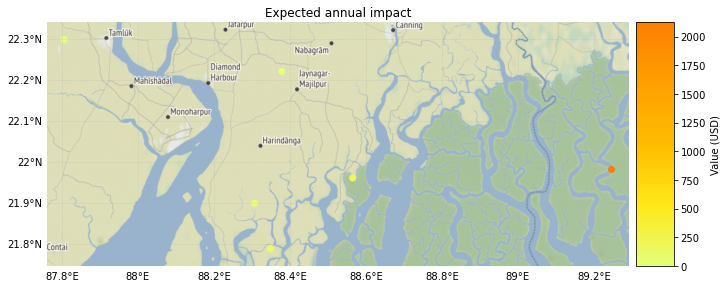

In [18]:
imp_pnt.plot_basemap_eai_exposure(buffer=5000)

### Making videos

Given a fixed exposure and impact functions, a sequence of hazards can be visualized hitting the exposures.

2021-04-30 13:13:09,080 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-04-30 13:13:09,086 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-04-30 13:13:09,088 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-04-30 13:13:09,097 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-04-30 13:13:09,100 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-04-30 13:13:10,128 - climada.util.finance - INFO - GDP CUB 2016: 9.137e+10.
2021-04-30 13:13:10,197 - climada.util.finance - INFO - Income group CUB 2016: 3.
2021-04-30 13:13:10,198 - climada.entity.exposures.black_marble - INFO - Nightlights from NASA's earth observatory for year 2016.
2021-04-30 13:13:18,224 - climada.entity.exposures.black_marble - INFO - Processing country Cuba.
2021-04-30 13:13:19,316 - climada.entity.exposures.black_marble - INFO - Generating resolution of ap

22it [09:40, 26.39s/it]                                                                                                                                                                                         


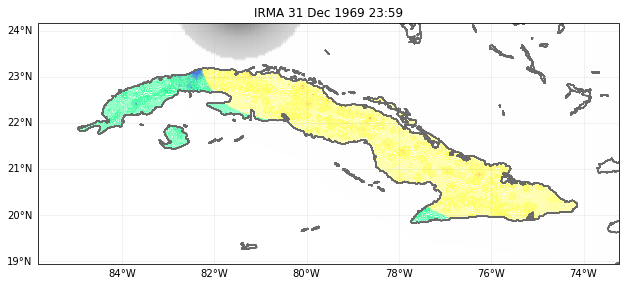

In [19]:
# exposure
from climada.entity import add_sea
from climada_petals.entity import BlackMarble

exp_video = BlackMarble()
exp_video.set_countries(['Cuba'], 2016, res_km=2.5)
exp_video.check()

# impact function
impf_def = ImpfTropCyclone.from_emanuel_usa()
impfs_video = ImpactFuncSet()
impfs_video.append(impf_def)
impfs_video.check()

# compute sequence of hazards using TropCyclone video_intensity method
exp_sea = add_sea(exp_video, (100, 5))
centr_video = Centroids.from_lat_lon(exp_sea.gdf.latitude.values, exp_sea.gdf.longitude.values)
centr_video.check()

track_name = '2017242N16333'
tr_irma = TCTracks.from_ibtracs_netcdf(provider='usa', storm_id=track_name) # IRMA 2017

tc_video = TropCyclone()
tc_list, _ = tc_video.video_intensity(track_name, tr_irma, centr_video) # empty file name to not to write the video

# generate video of impacts
file_name='./results/irma_imp_fl.gif'
imp_video = Impact()
imp_list = imp_video.video_direct_impact(exp_video, impfs_video, tc_list, file_name)
